In [2]:
import h5py
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

In [3]:
# Read in all 40 days of experimental data into a single 4D tensor
exp_days = 40

data_dir = '/Users/quetzal/Documents/code/blocking_project'
# Get the metadata (e.g., lat, long) from a single example data file
temp_day = 1
temp_filename = 'Z_5day_day' + str(temp_day) + '_20190730.mat'
meta_data = h5py.File(os.path.join(data_dir, temp_filename), 'r')
# # Construct the 40 x 127 x 43 x 7079 data file, corresponding to day, lat,
# # lon, trail_no values, of top-layer quasigeostrophic potential vorticity
data_shape = np.array(meta_data['Zluck']).shape
print("Data shape:", data_shape)

exp_data = np.zeros((exp_days, data_shape[0], data_shape[1], data_shape[2]));
for day in range(1, exp_days+1):
    filename = 'Z_5day_day' + str(day) + '_20190730.mat'
    print('Loading file for day ' + str(day), "from", filename)
    data = h5py.File(os.path.join(data_dir, filename), 'r');
    
#     print(list(data.items()))
    exp_data[day-1, :, :, :] = data['Zluck']; 


Data shape: (7079, 43, 127)
Loading file for day 1 from Z_5day_day1_20190730.mat
Loading file for day 2 from Z_5day_day2_20190730.mat
Loading file for day 3 from Z_5day_day3_20190730.mat
Loading file for day 4 from Z_5day_day4_20190730.mat
Loading file for day 5 from Z_5day_day5_20190730.mat
Loading file for day 6 from Z_5day_day6_20190730.mat
Loading file for day 7 from Z_5day_day7_20190730.mat
Loading file for day 8 from Z_5day_day8_20190730.mat
Loading file for day 9 from Z_5day_day9_20190730.mat
Loading file for day 10 from Z_5day_day10_20190730.mat
Loading file for day 11 from Z_5day_day11_20190730.mat
Loading file for day 12 from Z_5day_day12_20190730.mat
Loading file for day 13 from Z_5day_day13_20190730.mat
Loading file for day 14 from Z_5day_day14_20190730.mat
Loading file for day 15 from Z_5day_day15_20190730.mat
Loading file for day 16 from Z_5day_day16_20190730.mat
Loading file for day 17 from Z_5day_day17_20190730.mat
Loading file for day 18 from Z_5day_day18_20190730.mat


In [4]:
# Create time series visualization 
TRIAL_NO = 3958 # select trial number, 1 to 7079
option = 'top' # viewpoint, either top or side

# Initialize directory for snapshots
movie_dir = 'trial' + str(TRIAL_NO) + '_' + option
if not os.path.exists(movie_dir):
    os.makedirs(movie_dir)
    
# Create lat/lon meshgird
lon_cord, lat_cord = np.meshgrid(meta_data['lon0'], meta_data['lat0']);

# Surface plot of quasigeostrophic potential vorticity
for ii in range(exp_days):
    fig = plt.figure()
    
    if option == 'top':
        ax = fig.gca()        
        s = ax.contourf(lon_cord, lat_cord, exp_data[ii, TRIAL_NO, :, :], cmap=plt.cm.viridis)
    elif option == 'side':
        ax = fig.gca(projection='3d')
        ax.view_init(elev=52.2,azim=-53.1)    
        s = ax.plot_surface(lon_cord, lat_cord, exp_data[ii, TRIAL_NO, :, :], cmap=plt.cm.viridis, linewidth=0.2)
        
    filename = os.path.join(movie_dir, 'day'+str(ii)+'.png')
    plt.savefig(filename, dpi=96)
    plt.gca()
    plt.close()

Visualizing latitude [-0.74799825]


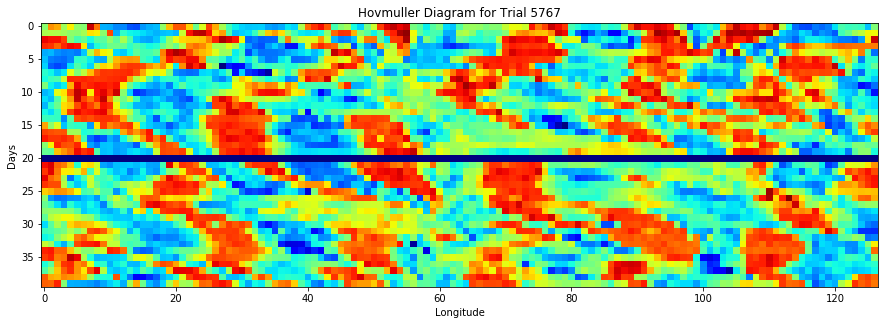

In [5]:
# Generate Longitude-wise Hovemuller diagram at single longitude for all trials 
# Visualize the zonal progress of pv anomolies at multiple trials for a single latitude 
NUM_TRIALS = 1 # should be a perfect square for plotting
trials_no = np.random.randint(data_shape[0], size=(NUM_TRIALS,)) 

# e.g., to probe at latitude 1.2467 select index 27 b/c meta_data.lat0(27) = 1.2476
lat_probe = 18
print("Visualizing latitude", meta_data['lat0'][lat_probe])


# Populate hovmuller data
hovmuller = np.zeros((NUM_TRIALS, exp_days, len(meta_data['lon0'])))
for p in range(NUM_TRIALS):
    for ii  in range(exp_days):
        hovmuller[p, ii, :] = exp_data[ii, trials_no[p], lat_probe, :]
    hovmuller[p, 20, :] = np.min(hovmuller, axis=None);
    
# Plot results
SIDE = int(np.sqrt(NUM_TRIALS))
fig, axs = plt.subplots(SIDE, SIDE, figsize=(15,10))

min_hov = np.min(hovmuller, axis=None)
max_hov = np.max(hovmuller, axis=None)

# set(gcf, 'Position', [1 258 2172 1087])
if NUM_TRIALS == 1:
    im = axs.imshow(hovmuller[p, :, :], cmap='jet', vmin=min_hov, vmax=max_hov)
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Days')
    axs.set_title('Hovmuller Diagram for Trial ' + str(trials_no[p]))
else:
    for p in range(NUM_TRIALS):
    #     print(p // SIDE, p % SIDE)
        im = axs[p // SIDE, p % SIDE].imshow(hovmuller[p, :, :], cmap='jet', vmin=min_hov, vmax=max_hov)
        axs[p // SIDE, p % SIDE].set_xlabel('Longitude')
        axs[p // SIDE, p % SIDE].set_ylabel('Days')
        axs[p // SIDE, p % SIDE].set_title('Hovmuller Diagram for Trial ' + str(trials_no[p]))

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)


plt.savefig('latitude' + str(lat_probe) + '_alltrials-hovmuller-diagram.png')


In [6]:
# Run POD Decomposition
# Run POD on all 40 days of samples trials
NUM_TRIALS = 100;
snapshot_trials = np.random.randint(data_shape[0], size=(NUM_TRIALS,)) 

snapshot_data = np.zeros((exp_days*NUM_TRIALS, data_shape[1], data_shape[2]))
for i in range(NUM_TRIALS):
    snapshot_data[i*exp_days:(i+1)*exp_days, :, :] = exp_data[:, snapshot_trials[i], :, :];

In [7]:
def pod(data):
    dims = data.shape
    
    # Remove the mean, to genreate modes of the ossilations around the mean
    data = data - np.tile(np.mean(data, axis=0), (dims[0], 1, 1))
    
    # Reshape the data
    data = data.reshape(dims[0], dims[1]*dims[2]);
    print("Computing SVD for data of shape:", data.shape)
    
    time_s = time.time()
    u, s, v = np.linalg.svd(data.T, full_matrices=False)
    print("Time for SVD:", time.time() - time_s)
    
    u = u.T
    u = u.reshape(dims)
    return u, s, v

u, s, v = pod(snapshot_data)

Computing SVD for data of shape: (4000, 5461)
Time for SVD: 38.703715085983276


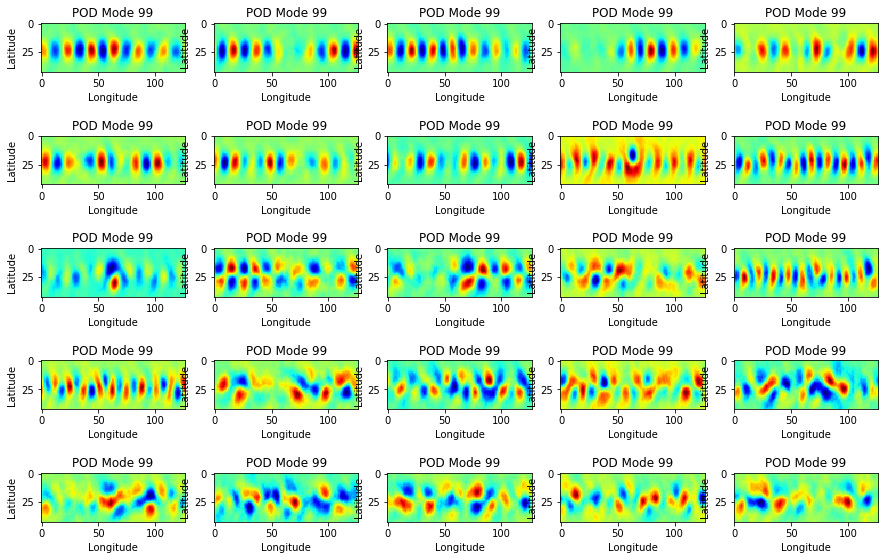

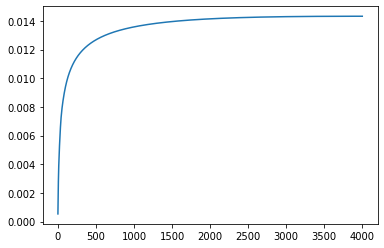

In [8]:
# Plot most energetic modes
PLOT_MODES = 25; # should be a perfect square
SIDE = int(np.sqrt(PLOT_MODES))
fig, axs = plt.subplots(SIDE, SIDE, figsize=(15,10))

for p in range(PLOT_MODES):
    im = axs[p // SIDE, p % SIDE].imshow(u[p, :, :], cmap='jet')
    axs[p // SIDE, p % SIDE].set_xlabel('Longitude')
    axs[p // SIDE, p % SIDE].set_ylabel('Latitude')
    axs[p // SIDE, p % SIDE].set_title('POD Mode ' + str(i))

plt.savefig('pod_bases_N' + str(PLOT_MODES) + '.png')

# Plot the energy present in each mode
fig = plt.figure()
plt.plot(np.cumsum(s**2))
plt.savefig('pod_energy_spectrum.png')

In [9]:
# For each snapshot, represent using POD coordiantes
print("U shape:", u.shape)
print("S shape:", s.shape)
print("V shape:", v.shape)

NUM_COMPS = 100
u = u[0:NUM_COMPS, :, :]
s = s[0:NUM_COMPS]
v = v[0:NUM_COMPS, 0:NUM_COMPS]
print("U new shape:", u.shape)
print("S new shape:", s.shape)
print("V new shape:", v.shape)

U shape: (4000, 43, 127)
S shape: (4000,)
V shape: (4000, 4000)
U new shape: (100, 43, 127)
S new shape: (100,)
V new shape: (100, 100)


In [10]:
# Run POD Decomposition
# Run POD on all 40 days of samples trials
NUM_TRIALS = 10;
snapshot_trials = np.random.randint(data_shape[0], size=(NUM_TRIALS,))

BD = 20
DB = 0
DA = 10
blocking_days = DB + DA
nonblocking_days = exp_days - DB - DA

blocking_data = np.zeros((blocking_days*NUM_TRIALS, data_shape[1], data_shape[2]))
nonblocking_data = np.zeros((nonblocking_days*NUM_TRIALS, data_shape[1], data_shape[2]))

for i in range(NUM_TRIALS):
    blocking_data[i*blocking_days:(i+1)*blocking_days, :, :] = exp_data[BD-DB:BD+DA, 
                                                                        snapshot_trials[i], 
                                                                        :, 
                                                                        :]
    
    nonblocking_data[i*nonblocking_days:i*nonblocking_days+BD-DB, :, :] = exp_data[0:BD-DB, 
                                                                                   snapshot_trials[i], 
                                                                                   :, 
                                                                                   :];  
    nonblocking_data[i*nonblocking_days+BD-DB:(i+1)*nonblocking_days, :, :] = exp_data[BD+DA:, 
                                                                                       snapshot_trials[i], 
                                                                                       :, 
                                                                                       :];      
print("Total nonblocking shape:\t", nonblocking_data.shape)
print("Total blocking shape:\t\t", blocking_data.shape)

Total nonblocking shape:	 (300, 43, 127)
Total blocking shape:		 (100, 43, 127)


In [11]:
def pod_components(data, pod):
    dims = data.shape
    pod_dims = pod.shape

    
    # Remove the mean, to genreate modes of the ossilations around the mean
    data = data - np.tile(np.mean(data, axis=0), (dims[0], 1, 1))
    
    # Reshape the data
    data = data.reshape(dims[0], dims[1]*dims[2]);
    pod = pod.reshape(pod_dims[0], pod_dims[1]*pod_dims[2]);

    comp = pod @ data.T
    return comp

# Get POD components for blocking and nonblocking data
xn = pod_components(nonblocking_data, u)
xb = pod_components(blocking_data, u)

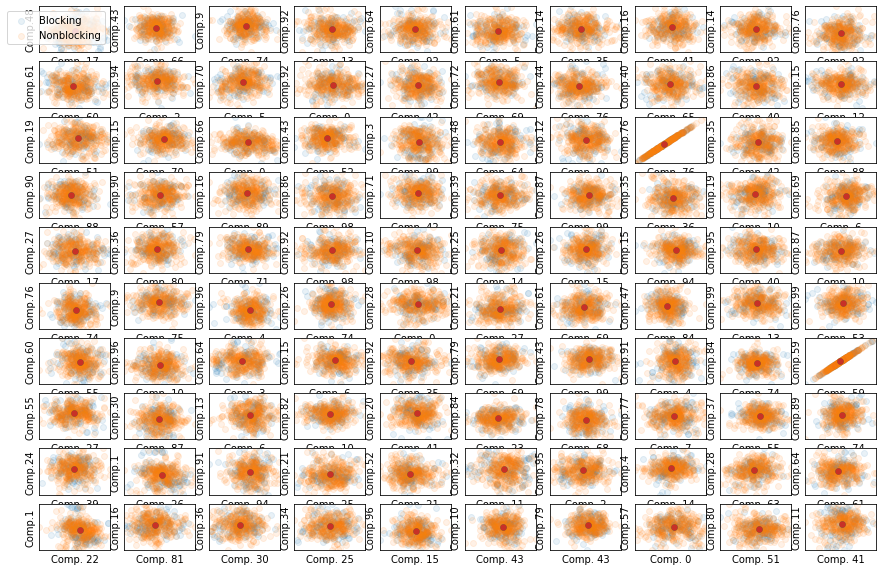

In [12]:
NUM_TESTS = 100;
components = np.random.randint(u.shape[0], size=(NUM_TESTS,2))

# Plot results
SIDE = int(np.sqrt(NUM_TESTS))
fig, axs = plt.subplots(SIDE, SIDE, figsize=(15,10))
# fig, axs = plt.subplots(SIDE, SIDE)


for p in range(NUM_TESTS):
    axs[p // SIDE, p % SIDE].scatter(xb[components[p, 0], :], xb[components[p, 1], :], alpha=0.1, label='Blocking')
    axs[p // SIDE, p % SIDE].scatter(xn[components[p, 0], :], xn[components[p, 1], :], alpha=0.1, label='Nonblocking')
    axs[p // SIDE, p % SIDE].scatter(np.mean(xb[components[p, 0], :]), np.mean(xb[components[p, 1], :]), alpha=0.9, s=30)
    axs[p // SIDE, p % SIDE].scatter(np.mean(xn[components[p, 0], :]), np.mean(xn[components[p, 1], :]), alpha=0.9, s=30)

    xmin = min(min(xb[components[p, 0], :]), min(xn[components[p, 0], :]))
    xmax = max(max(xb[components[p, 0], :]), max(xn[components[p, 0], :]))
    ymin = min(min(xb[components[p, 1], :]), min(xn[components[p, 1], :]))
    ymax = max(max(xb[components[p, 1], :]), max(xn[components[p, 1], :]))

    axs[p // SIDE, p % SIDE].set_xlim([xmin, xmax])
    axs[p // SIDE, p % SIDE].set_ylim([ymin, ymax]) 
    
    axs[p // SIDE, p % SIDE].set_xticks([])
    axs[p // SIDE, p % SIDE].set_yticks([])
    if p == 0:
        axs[p // SIDE, p % SIDE].legend()

    
    axs[p // SIDE, p % SIDE].set_xlabel('Comp. ' + str(components[p, 0]))
    axs[p // SIDE, p % SIDE].set_ylabel('Comp.' + str(components[p, 1]))
#     axs[p // SIDE, p % SIDE].set_title('Blocking versus Nonblocking POD Components')

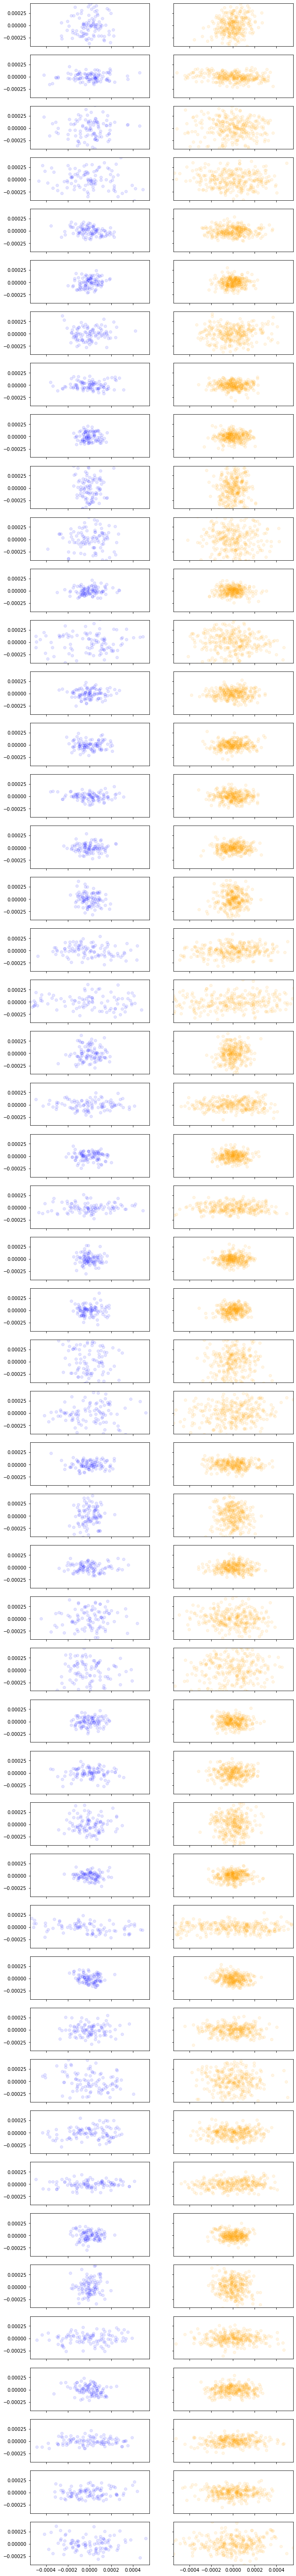

In [13]:
NUM_TESTS = 50;
components = np.random.randint(u.shape[0], size=(NUM_TESTS,2))

fig, axs = plt.subplots(NUM_TESTS, 2, figsize=(10,100), sharex=True, sharey=True)

for p in range(NUM_TESTS):
    axs[p, 0].scatter(xb[components[p, 0], :], xb[components[p, 1], :], alpha=0.1, label='Blocking', color='blue')
    axs[p, 1].scatter(xn[components[p, 0], :], xn[components[p, 1], :], alpha=0.1, label='Nonblocking', color='orange')
#     axs[p, 0].scatter(np.mean(xb[components[p, 0], :]), np.mean(xb[components[p, 1], :]), alpha=0.9, s=30)
#     axs[p, 1].scatter(np.mean(xn[components[p, 0], :]), np.mean(xn[components[p, 1], :]), alpha=0.9, s=30)

    xmin = min(min(xb[components[p, 0], :]), min(xn[components[p, 0], :]))
    xmax = max(max(xb[components[p, 0], :]), max(xn[components[p, 0], :]))
    ymin = min(min(xb[components[p, 1], :]), min(xn[components[p, 1], :]))
    ymax = max(max(xb[components[p, 1], :]), max(xn[components[p, 1], :]))

    axs[p, 0].set_xlim([xmin, xmax])
    axs[p, 0].set_ylim([ymin, ymax]) 
    axs[p, 1].set_xlim([xmin, xmax])
    axs[p, 1].set_ylim([ymin, ymax]) 
    
#     axs[p, 0].set_xticks([])
#     axs[p, 0].set_yticks([])
#     axs[p, 1].set_xticks([])
#     axs[p, 1].set_yticks([])
    
#     axs[p, 0].set(adjustable='box', aspect='equal')
#     axs[p, 1].set(adjustable='box', aspect='equal')
#     axs[p, 0].set(aspect='equal')
#     axs[p, 1].set(aspect='equal')
#     axs[p, 0].set(adjustable='box')
#     axs[p, 1].set(adjustable='box')
    
#     axs[p // SIDE, p % SIDE].set_xlabel('Comp. ' + str(components[p, 0]))
#     axs[p // SIDE, p % SIDE].set_ylabel('Comp.' + str(components[p, 1]))

In [14]:
x_data = np.zeros((exp_data.shape[0], exp_data.shape[1], u.shape[0]))
for trial in range(exp_data.shape[1]):
#     pdb.set_trace()
    x_data[:, trial, :] = pod_components(exp_data[:, trial, :, :], u).T

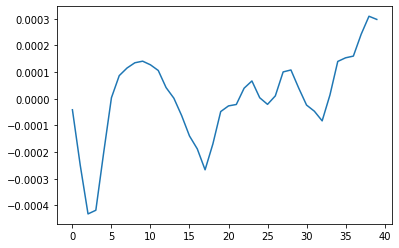

In [15]:
plt.plot(x_data[:, 5, 0])

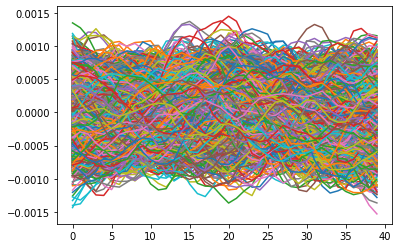

In [16]:
for trial in range(exp_data.shape[1]):
    plt.plot(x_data[:, trial, 0])

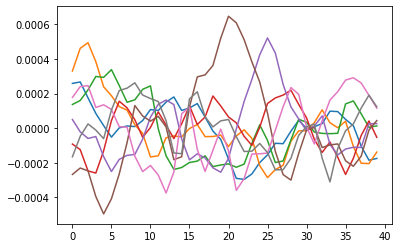

In [17]:
for comp in range(8):
    plt.plot(x_data[:, 3, comp])